# Bootstrapping aggregation (Bagging)

*Bootstrapping* es una técnica de remuestreo utilizada en estadística.<br>
*Aggregation* hace referencia a la agreagación de varios clasificadores.

Bagging es la combinación de un clasificador *base* entrenado con diferentes submuestreos del conjunto de datos. 

---
    [ES] Código de Alfredo Cuesta Infante para 'Reconocimiento de Patrones'
       @ Master Universitario en Visión Artificial, 2021, URJC (España)
    [EN] Code by Alfredo Cuesta-Infante for 'Pattern Recognition'
       @ Master of Computer Vision, 2021, URJC (Spain)

    alfredo.cuesta@urjc.es

### Preliminares 

En la siguiente celda se realizan los siguientes pasos:
1. carga de módulos genéricos
2. leer los datos y cargarlos en dataframes
2. extraer características
2. separar en TRAIN y VALID
2. seleccionar características y escalar TRAIN a [0,1]

In [1]:
#-[1]. Load data from CSV and put all in a single dataframe 'FullSet'

import numpy  as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
sys.path.append('../MyUtils/')
import MyUtils as my
seed = 1234 #<- random generator seed (comment to get randomness)

#-[2]. Load data from CSV and put all in a single dataframe 'FullSet'

FullSet_0 = pd.read_csv('../Datasets/1000ceros.csv', header=None)
FullSet_1 = pd.read_csv('../Datasets/1000unos.csv',  header=None)
FullSet = my.join_features_labels(FullSet_0,FullSet_1)

#-[3]. Convert the 'FullSet' of pixels into the set 'X_full' of features and get the set 'Y_full' of labels

theta = 0.5
X_full = my.mnist_features( FullSet.drop('label', axis=1), theta=theta )
Y_full = FullSet[['label']]

#-[4]. Split X_full into TRAIN and TEST in a single Stratified split

valid_size = 0.2
X_train, Y_train, X_valid, Y_valid = \
   my.single_stratified_split( X_full,Y_full, test_size=valid_size, random_state=seed)

#-[5]. Select the features and fit a scaler to [0,1]

from sklearn.preprocessing import MinMaxScaler

#feat_selec= ['width','height']
feat_selec= ['W_max1','H_max1']
scaler = MinMaxScaler()

X = scaler.fit_transform(X_train[feat_selec])
Y = Y_train.values.ravel()   

#---> X and Y are now numpy arrays ready to train a machine !!

## Combinación por *bagging*

A diferencia de la combinación mediante votacion, ahora sólo utilizamos un clasificador base, y lo que elegimos es el número de muestras del muestreo.

También podemos elegir si el muestreo se hace con o sin remplazo.<br>
 -- Si es **con** remplazo $\rightarrow$ **bagging**<br>
 -- Si es **sin** remplazo $\rightarrow$ **pasting**<br>

Más en [*BaggingClassifier*, de Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)


#### Entrenar 
Es interesante comprobar que con clasificadores muy sencillos como árboles de decisión de profundidad 1 se logra obtener superficies de decisión no lineales.

In [2]:
# --- LEARN Bagging ensemble --------------
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

choice_clf = 'DT' # 'Linear', 'SVC', 'NBC' , 'DT'
n_estimators= 500
max_samples = 10
bootstrap = True

lin_clf = LogisticRegression()
svm_clf = SVC(kernel='rbf',C=1,probability=True)
tree_clf = DecisionTreeClassifier(max_depth=1)
nbc_clf = GaussianNB()

if choice_clf == 'Linear':
    bag_clf = BaggingClassifier(base_estimator=lin_clf,
                                bootstrap=bootstrap, n_estimators=n_estimators, max_samples=max_samples)
elif choice_clf == 'SVC':
    bag_clf = BaggingClassifier(base_estimator=svm_clf,
                                bootstrap=bootstrap, n_estimators=n_estimators, max_samples=max_samples)
elif choice_clf == 'NBC':
    bag_clf = BaggingClassifier(base_estimator=nbc_clf,
                                bootstrap=bootstrap, n_estimators=n_estimators, max_samples=max_samples)
elif choice_clf == 'DT':
    bag_clf = BaggingClassifier(base_estimator=tree_clf,
                                bootstrap=bootstrap, n_estimators=n_estimators, max_samples=max_samples)
else:
    print('Choose one base classifier')

bag_clf.fit(X,Y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                  max_samples=10, n_estimators=500)

#### Visualizar

In [3]:
#--parameters of this cell
Ngrid = 100
threshold = 0.5 # Set 0 < threshold < 1 to make a hard classification.
cmap = 'summer'  # 'jet' 'hot' 'cool' 'spring' 'summer' 'winter'

#--take Ngrid x Ngrid equally spaced points in [0,1]x[0,1]
rangeX = np.linspace(0,1,Ngrid)
rangeY = np.linspace(0,1,Ngrid)
xx,yy = np.meshgrid(rangeX,rangeY)
grid_data = np.hstack( (xx.reshape([xx.size,1]),    \
                        yy.reshape([yy.size,1]) ) )

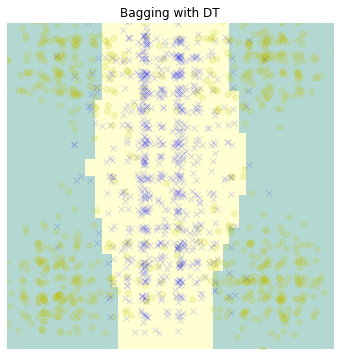

In [4]:
unit_interv = [0,1,0,1]
origin = 'lower'
plt.rcParams['figure.figsize'] = [6,6] #<- this makes the figures larger in Jupyter

sigma=0.01
alpha=0.3


tag_hat = bag_clf.predict(grid_data)
tag_hat = tag_hat.reshape([Ngrid,Ngrid])
ix1 = Y>0
ix0 = ~ix1
x1_zeros = my.jitter(X[ix0,0],sigma=sigma)
x2_zeros = my.jitter(X[ix0,1],sigma=sigma)
x1_ones = my.jitter(X[ix1,0],sigma=sigma)
x2_ones = my.jitter(X[ix1,1],sigma=sigma)
plt.imshow(tag_hat, origin="lower", extent=unit_interv, cmap=cmap, alpha=alpha)
plt.plot(x1_zeros, x2_zeros, 'yo', alpha=.15)
plt.plot(x1_ones, x2_ones, 'bx', alpha=.15)
if bootstrap:
    strTitle = "Bagging with %s" %(choice_clf)
else:
    strTitle = "Pasting with %s" % (choice_clf)
plt.title(strTitle)
plt.axis(unit_interv)

plt.axis('off')

plt.show()

In [5]:
y_pred = bag_clf.predict( scaler.transform(X_valid[feat_selec]) )

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(Y_valid.values, y_pred)
N_success = conf_mat[0,0]+conf_mat[1,1]
N_fails = conf_mat[0,1]+conf_mat[1,0]

print("Outcome:")
strlog = "  :) HIT  = %d, (%0.2f%%)"%(N_success, 100*N_success/(N_success+N_fails))
print(strlog)
strlog = "  :( FAIL = %d, (%0.2f%%)"%(N_fails, 100*N_fails/(N_success+N_fails))
print(strlog)


Outcome:
  :) HIT  = 358, (89.50%)
  :( FAIL = 42, (10.50%)
